Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [17]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import os
import math
import random
import zipfile
import collections
import numpy as np
import seaborn as sns
import tensorflow as tf
from six.moves import range
from matplotlib import pylab
from sklearn.manifold import TSNE
from __future__ import print_function
from six.moves.urllib.request import urlretrieve

%matplotlib inline

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [11]:
vocabulary_size = 50000

def build_dataset(words):
    # find the count of vocb size most common words in corpus
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    # create dictionary assigning number to each word in vocab
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    # encode the corpus with the id assigned to the word
    data = list()
    unk_count = 0
    for word in words:
        # if the word in dict
        if word in dictionary:
            index = dictionary[word]
        # else label unknown
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)

    # update unknown words count
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

# buildng dictionary
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
  
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # [skip_window target skip_window]
    span = 2*skip_window+1 
    # word buffer for generating vector
    buffer = collections.deque(maxlen=span)
    
    # read enough words for the span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
  
    # now generate the skip gram model
    for i in range(batch_size // num_skips):
        # target label at the center of the buffer
        # index is skip_window
        target = skip_window  
        # targets that need to be avoided at index skip_window
        targets_to_avoid = [skip_window]
       
        # add values to batch and label variables
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            labels[i*num_skips+j,0] = buffer[target]
            batch[i*num_skips+j] = buffer[skip_window]
         
        # update the buffer
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'anarchism', 'originated', 'of', 'term', 'as', 'originated']


Train a skip-gram model.

In [13]:
# How many times to reuse an input to generate a label.
num_skips = 2 
# How many words to consider left and right.
skip_window = 1 
# batch size for training
batch_size = 128
# Dimension of the embedding vector.
embedding_size = 128

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 

# Random set of words to evaluate similarity on
valid_size = 16 
# Only pick dev samples in the head of the distribution.
valid_window = 100 
valid_examples = np.array(random.sample(range(valid_window), valid_size))

# Number of negative examples to sample.
num_sampled = 64 

# generate computation graph
graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                     train_labels, num_sampled, vocabulary_size))


    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    # main loop
    average_loss = 0
    for step in range(num_steps):
        # generating batch for training
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        # feed dictionary for optimizer
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        
        # run optimizer
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        # print avg loss for every 2000 steps
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
    
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()            
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.115250
Nearest to his: innkeeper, entitled, sheedy, jabal, goodman, paddock, yankee, monsoons,
Nearest to used: kis, disease, upholds, intermarriage, margherita, jewellery, cyclists, scanner,
Nearest to state: bush, helpers, intimate, guile, cathari, apr, yster, stirrup,
Nearest to up: dost, band, albums, kal, bennett, garbled, sholom, metamorphosis,
Nearest to eight: kuznetsov, agilent, surveys, spotted, infty, sherry, gladius, subjected,
Nearest to between: zoologists, tyrol, goldsmiths, dumpster, directional, moncton, abdicate, obfuscation,
Nearest to many: genoa, peacetime, rosetta, round, negus, lancer, tape, primers,
Nearest to be: dustin, thermonuclear, pedestrian, maximin, aster, archon, zhukov, garnered,
Nearest to has: brainchild, spalding, compatibility, hinckley, lughnasadh, rationalistic, alus, moluccas,
Nearest to called: plebeians, sakharov, seq, suppressed, elwes, rowing, quae, specialises,
Nearest to three: tubules, pleiades, aztec

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=8000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1,:])

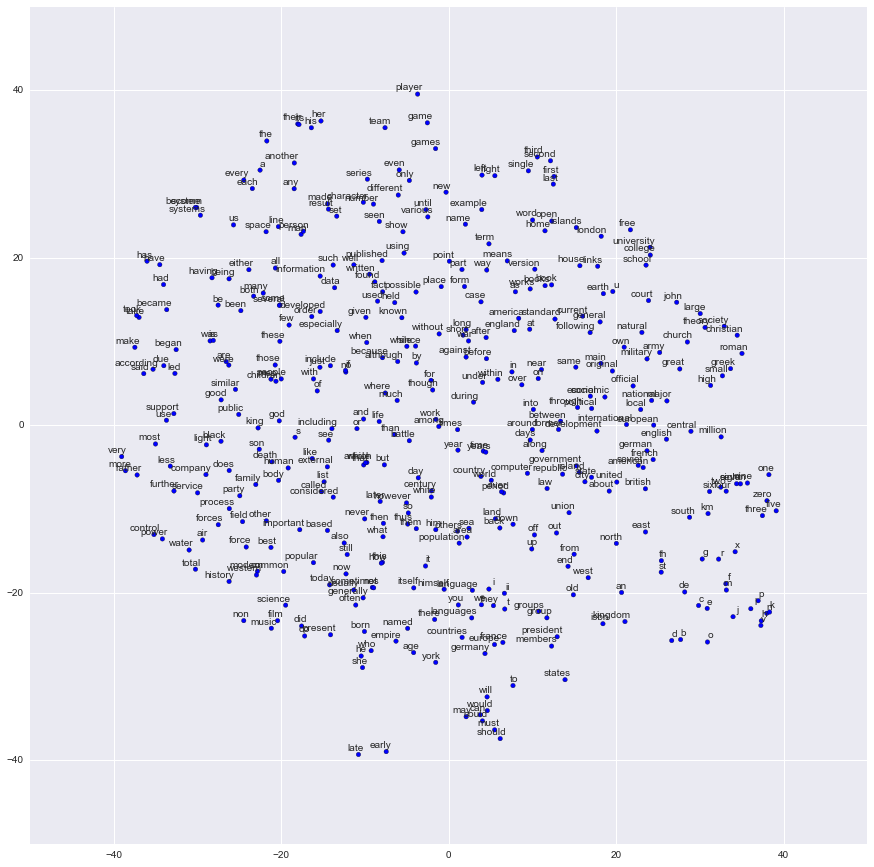

In [18]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---